In [1]:
import os
import cv2
import tensorflow as tf

In [2]:
folders = {
    'train_x' : os.path.join('train', 'membrane_x'),
    'train_y' : os.path.join('train', 'membrane_y'),
    'test_x' : os.path.join('test', 'membrane_x'),
    'test_y' : os.path.join('test', 'membrane_y')
}

In [3]:
for folder in folders:
    if not os.path.exists(folder):
        !mkdir -p {folder}

In [4]:
import numpy as np
train_x = np.zeros((25, 256, 256, 3), dtype=np.float32)
train_y = np.zeros((25, 256, 256), dtype=np.float32)

for i, eachImage in enumerate(os.listdir(folders['train_x'])):
    img = cv2.imread(os.path.join(folders['train_x'], eachImage),cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_NEAREST)
    img = img / 255
    train_x[i] = img
    
    mask = cv2.imread(os.path.join(folders['train_y'], str(i)+'_predict.png'), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256,256))
    mask = mask/255
    train_y[i] = mask

In [5]:
test_x = np.zeros((5, 256, 256, 3), dtype=np.float32)
test_y = np.zeros((5, 256, 256), dtype=np.float32)

for i, eachImage in enumerate(os.listdir(folders['test_x'])):
    img = cv2.imread(os.path.join(folders['test_x'], eachImage),cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256,256))
    img = img / 255
    test_x[i] = img
    
    mask = cv2.imread(os.path.join(folders['test_y'], str(25 + i)+'_predict.png'),cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256,256))
    mask = mask/255
    test_y[i] = mask

In [6]:
test_y.shape

(5, 256, 256)

In [7]:
inputs = tf.keras.layers.Input(shape=(256, 256, 3))

c0 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(inputs)
c1 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(c0)  # This layer for concatenating in the expansive part
c2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c1)

c3 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(c2)
c4 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(c3)  # This layer for concatenating in the expansive part
c5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c4)

c6 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(c5)
c7 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(c6)  # This layer for concatenating in the expansive part
c8 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c7)

c9 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(c8)
c10 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(c9)  # This layer for concatenating in the expansive part
c11 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c10)

c12 = tf.keras.layers.Conv2D(1024, activation='relu', kernel_size=3, padding='same')(c11)
c13 = tf.keras.layers.Conv2D(1024, activation='relu', kernel_size=3, padding='same')(c12)

# We will now start the second part of the U - expansive part
t01 = tf.keras.layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu', padding='same')(c13)
concat01 = tf.keras.layers.concatenate([t01, c10])
c14 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(concat01)
c15 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(c14)

t02 = tf.keras.layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu', padding='same')(c15)
concat02 = tf.keras.layers.concatenate([t02, c7])
c16 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(concat02)
c17 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(c16)

t03 = tf.keras.layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu',padding='same')(c17)
concat03 = tf.keras.layers.concatenate([t03, c4])
c18 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(concat03)
c19 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(c18)

t04 = tf.keras.layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu', padding='same')(c19)
concat04 = tf.keras.layers.concatenate([t04, c1])
c20 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(concat04)
c21 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(c20)

outputs = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(c21)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

In [8]:
model.summary()

Model: "u-netmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_________________________________________________________________________________________

In [9]:
model.build(input_shape=(25, 256, 256, 3))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/logs/")

result = model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    batch_size=2,
    epochs=10,
    steps_per_epoch=len(train_x)//2,
    validation_steps=len(test_x)//2
)#, callbacks=[tensorboard_callback])

Epoch 1/10
12/12 [==============================] - 78s 6s/step - loss: 0.5980 - accuracy: 0.6748 - val_loss: 0.4971 - val_accuracy: 0.6953
Epoch 2/10
12/12 [==============================] - 75s 6s/step - loss: 0.5158 - accuracy: 0.6705 - val_loss: 0.4910 - val_accuracy: 0.6953
Epoch 3/10
12/12 [==============================] - 73s 6s/step - loss: 0.5179 - accuracy: 0.6657 - val_loss: 0.4907 - val_accuracy: 0.6953
Epoch 4/10
12/12 [==============================] - 72s 6s/step - loss: 0.5120 - accuracy: 0.6725 - val_loss: 0.4909 - val_accuracy: 0.6953
Epoch 5/10
12/12 [==============================] - 72s 6s/step - loss: 0.5033 - accuracy: 0.6732 - val_loss: 0.4910 - val_accuracy: 0.6953
Epoch 6/10
12/12 [==============================] - 73s 6s/step - loss: 0.5054 - accuracy: 0.6767 - val_loss: 0.4909 - val_accuracy: 0.6953
Epoch 7/10
12/12 [==============================] - 72s 6s/step - loss: 0.5120 - accuracy: 0.6733 - val_loss: 0.4921 - val_accuracy: 0.6953
Epoch 8/10
12/12 [==

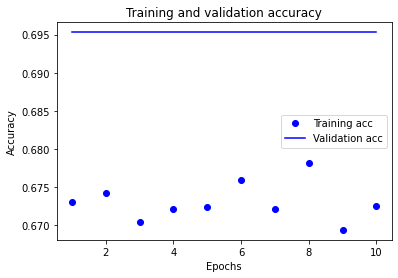

In [23]:
import matplotlib.pyplot as plt

ac = result.history['accuracy']
val_ac = result.history['val_accuracy']

plt.plot(range(1, len(ac)+1), ac, 'bo', label='Training acc')
plt.plot(range(1, len(val_ac)+1), val_ac, 'b', label='Validation acc')
       
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
predicted_result = model.predict(test_x)

In [27]:
type(predicted_result)

numpy.ndarray

In [42]:
cv2.imshow('Pred', predicted_result[2])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [41]:
plt.figure(figsize=(15, 15))
for i in range(0, len(predicted_result)):
    plt.imshow(predicted_result[i])
    plt.axis('off')
plt.show()

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 1080x1080 with 0 Axes>